In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import random
import os
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, pyll
import time

import pickle
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install catboost

     |████████████████████████████████| 65.7MB 57kB/s 


In [ ]:
data_train = pd.read_csv('/content/train_Df64byy.csv')
data_test = pd.read_csv('/content/test_YCcRUnU.csv')

In [ ]:
data_train.shape,data_test.shape

((50882, 14), (21805, 13))

In [ ]:

data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       50882 non-null  int64  
 1   City_Code                50882 non-null  object 
 2   Region_Code              50882 non-null  int64  
 3   Accomodation_Type        50882 non-null  object 
 4   Reco_Insurance_Type      50882 non-null  object 
 5   Upper_Age                50882 non-null  int64  
 6   Lower_Age                50882 non-null  int64  
 7   Is_Spouse                50882 non-null  object 
 8   Health Indicator         39191 non-null  object 
 9   Holding_Policy_Duration  30631 non-null  object 
 10  Holding_Policy_Type      30631 non-null  float64
 11  Reco_Policy_Cat          50882 non-null  int64  
 12  Reco_Policy_Premium      50882 non-null  float64
 13  Response                 50882 non-null  int64  
dtypes: float64(2), int64(6

In [ ]:
print('Null value in train data: ',data_train.isnull().sum().sum())
data_train.isnull().sum()

Null value in train data:  52193


ID                             0
City_Code                      0
Region_Code                    0
Accomodation_Type              0
Reco_Insurance_Type            0
Upper_Age                      0
Lower_Age                      0
Is_Spouse                      0
Health Indicator           11691
Holding_Policy_Duration    20251
Holding_Policy_Type        20251
Reco_Policy_Cat                0
Reco_Policy_Premium            0
Response                       0
dtype: int64

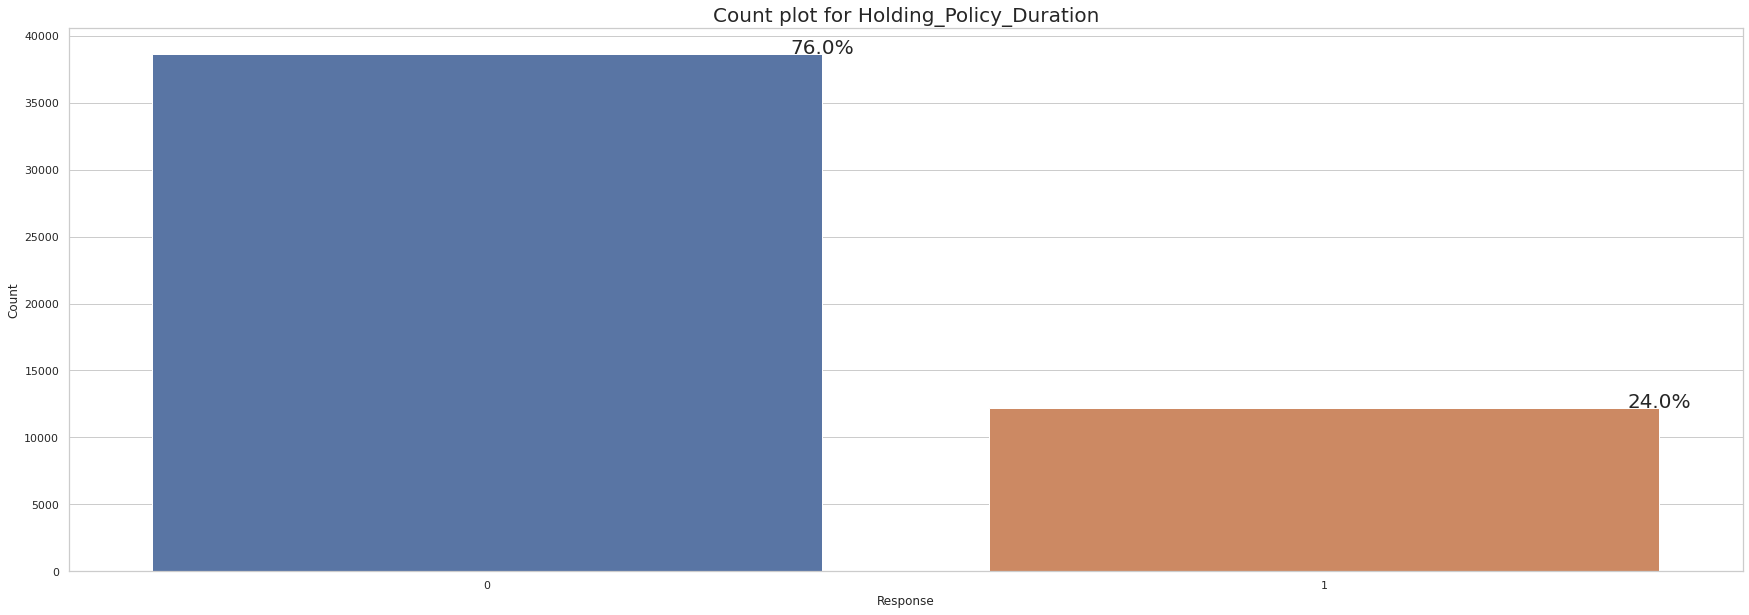

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(30,10))
total = data_train.shape[0]
ax = sns.countplot(x = 'Response',data = data_train)
ax.set_ylabel('')
for p in ax.patches:
  percentage = '{:.1f}%'.format(100 * p.get_height()/total)
  x = p.get_x() + p.get_width()
  y = p.get_height()
  ax.annotate(percentage, (x, y),ha='center',fontsize = 20)
  plt.ylabel('Count')
  plt.title('Count plot for Holding_Policy_Duration',fontdict = {'fontsize' : 20})

In [ ]:

for col in data_test.select_dtypes('object').columns:
    print(col, data_test[col].nunique())

City_Code 36
Accomodation_Type 2
Reco_Insurance_Type 2
Is_Spouse 2
Health Indicator 9
Holding_Policy_Duration 15


Imputing NaN

In [ ]:

data_train['Health Indicator'].unique()

array(['X1', 'X2', nan, 'X4', 'X3', 'X6', 'X5', 'X8', 'X7', 'X9'],
      dtype=object)

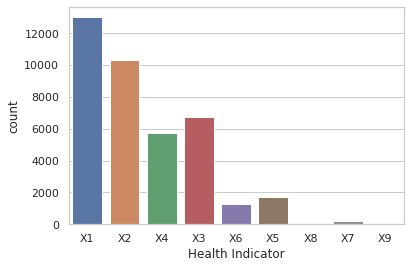

In [ ]:

sns.countplot(data_train['Health Indicator'])

In [ ]:

most_freq = data_train['Health Indicator'].mode()[0]
print(most_freq)

data_train['Health Indicator'] = data_train['Health Indicator'].fillna(most_freq)
data_test['Health Indicator'] = data_test['Health Indicator'].fillna(most_freq)

X1


Imputing : Holding_Policy_Duration

In [ ]:
data_train['Holding_Policy_Duration'].unique()

array(['14+', nan, '1.0', '3.0', '5.0', '9.0', '14.0', '7.0', '2.0',
       '11.0', '10.0', '8.0', '6.0', '4.0', '13.0', '12.0'], dtype=object)

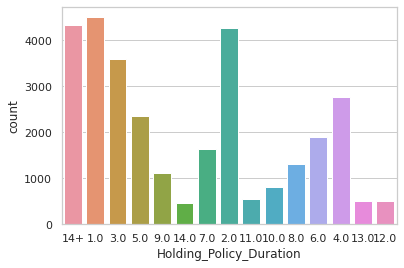

In [ ]:

sns.countplot(data_train['Holding_Policy_Duration'])

In [ ]:
# most_freq = train_df['Holding_Policy_Duration'].mode()[0]
most_freq = str(0.0)
print(most_freq)

data_train['Holding_Policy_Duration'] = data_train['Holding_Policy_Duration'].fillna(most_freq)
data_test['Holding_Policy_Duration'] = data_test['Holding_Policy_Duration'].fillna(most_freq)

0.0


Imputing : Holding_Policy_Type

In [ ]:

data_train['Holding_Policy_Type'].unique()

array([ 3., nan,  1.,  4.,  2.])

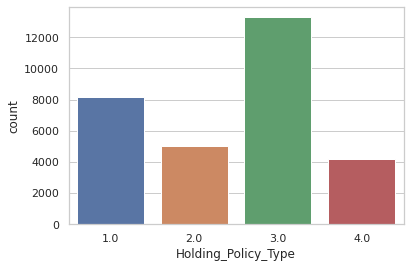

In [ ]:
sns.countplot(data_train['Holding_Policy_Type'])

In [ ]:
# most_freq = train_df['Holding_Policy_Type'].mode()[0]
most_freq = 'no_policies'
print(most_freq)

data_train['Holding_Policy_Type'] = data_train['Holding_Policy_Type'].fillna(most_freq)
data_test['Holding_Policy_Type'] = data_test['Holding_Policy_Type'].fillna(most_freq)

no_policies


In [ ]:

data_train.columns

Index(['ID', 'City_Code', 'Region_Code', 'Accomodation_Type',
       'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse',
       'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type',
       'Reco_Policy_Cat', 'Reco_Policy_Premium', 'Response'],
      dtype='object')

In [ ]:
data_train['Holding_Policy_Type'] = data_train['Holding_Policy_Type'].astype(str)
data_test['Holding_Policy_Type'] = data_test['Holding_Policy_Type'].astype(str)

data_train['Reco_Policy_Cat'] = data_train['Reco_Policy_Cat'].astype(str)
data_test['Reco_Policy_Cat'] = data_test['Reco_Policy_Cat'].astype(str)

data_train['Region_Code'] = data_train['Region_Code'].astype(str)
data_test['Region_Code'] = data_test['Region_Code'].astype(str)

In [ ]:

cols_to_remove = ['ID']
target = 'Response'

X = data_train.drop(cols_to_remove + [target], axis=1)
y = data_train[target]
X_TEST = data_test.drop(cols_to_remove , axis=1)

In [ ]:
X.shape,X_TEST.shape

((50882, 12), (21805, 12))

sPLIT

In [ ]:
X_train , X_valid, y_train, y_valid = train_test_split(X,y, 
                                                       test_size=0.2, 
                                                       random_state=9, 
                                                       stratify=y)

In [ ]:
cat_columns = []
for col in X_train.select_dtypes('object').columns:
    print(col)
    cat_columns.append(col)


City_Code
Region_Code
Accomodation_Type
Reco_Insurance_Type
Is_Spouse
Health Indicator
Holding_Policy_Duration
Holding_Policy_Type
Reco_Policy_Cat


In [ ]:
cat_level_count_train_dict = {i : dict(X_train.groupby(i)['Region_Code'].count()) for i in cat_columns}
cat_level_count_train_dict['Accomodation_Type']

{'Owned': 22361, 'Rented': 18344}

In [ ]:
cat_level_count_train_dict.keys()

dict_keys(['City_Code', 'Region_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Is_Spouse', 'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat'])

In [ ]:
mismatch_cat_features=[]
for col in cat_columns:
  if (set(cat_level_count_train_dict[col].keys()) - set(X_valid[col].unique())) or (set(X_valid[col].unique()) - set(cat_level_count_train_dict[col].keys())):
    mismatch_cat_features.append(col)
print('Features that have mismatch of levels in train and valid set are :',mismatch_cat_features)
print('Number of categorical features that has mismatch in levels are: ',len(mismatch_cat_features))

Features that have mismatch of levels in train and valid set are : ['Region_Code']
Number of categorical features that has mismatch in levels are:  1


In [ ]:
def search_feature(x,combine_set):
  #print(combine_set)
  if x in combine_set:
      return np.nan
  return x


for col in cat_columns:

  if (set(cat_level_count_train_dict[col].keys()) - set(X_valid[col].unique())) or (set(X_valid[col].unique()) - set(cat_level_count_train_dict[col].keys())) :
    #print('yes')
    unique_train = set(cat_level_count_train_dict[col].keys())
    unique_test = set(X_valid[col].unique())
    rem_train = unique_train-unique_test
    rem_test = unique_test-unique_train
    print('rem_train',rem_train)
    print('rem_test',rem_test)
    combine_set = rem_train.union(rem_test)
    print('combine_set',combine_set)
    mapp_nan = {i: np.nan for i in combine_set }
    #print( mapp_nan)
    #uniq_nan_testdf['cat92'] = uniq_nan_testdf['cat92'].map(mapp_nan)

    X_valid[col] = X_valid[col].apply(lambda x: search_feature(x,combine_set),1)

rem_train {'2293', '3087', '1229', '5052', '5798', '2758', '5881', '6140', '3649', '5407', '5509', '5710', '5246', '3716', '898', '5107', '5519', '3354', '6092', '5190', '5230', '6189', '6146', '5439', '4513', '3410', '5679', '4881', '5310', '5361', '6001', '6124', '4260', '5188', '6116', '6193', '6020', '5041', '5864', '5617', '4714', '5085', '6151', '5820', '5933', '5155', '5556', '3722', '4734', '5156', '3141', '2829', '2797', '5374', '4127', '4845', '3453', '3476', '3689', '5474', '5648', '5700', '5049', '3810', '5036', '5315', '3987', '5571', '5208', '5505', '4905', '4927', '1879', '5456', '4837', '5726', '4955', '4521', '4856', '2985', '6030', '2774', '3754', '6135', '4039', '3229', '2337', '3308', '4403', '6042', '5168', '5633', '5169', '4114', '5366', '4871', '4588', '3932', '4582', '4371', '4895', '3757', '6059', '4968', '1812', '4829', '3433', '4100', '3579', '5089', '4244', '2579', '4264', '5249', '5745', '5006', '2363', '5271', '5905', '3845', '4956', '6006', '3836', '4618'

In [ ]:
X_valid.isnull().sum()

City_Code                    0
Region_Code                197
Accomodation_Type            0
Reco_Insurance_Type          0
Upper_Age                    0
Lower_Age                    0
Is_Spouse                    0
Health Indicator             0
Holding_Policy_Duration      0
Holding_Policy_Type          0
Reco_Policy_Cat              0
Reco_Policy_Premium          0
dtype: int64

In [ ]:

label_encoded_map_dict = {}
for col in cat_columns:
    z = {k: i+1 for i, k in enumerate(X_train.groupby([col])['Region_Code'].count().sort_values().index)}
    z[np.nan] = -1
    label_encoded_map_dict[col] = z

In [ ]:
data_train.groupby(['City_Code'])['Response'].count()

City_Code
C1     8973
C10    1611
C11    1147
C12     868
C13    1005
C14     746
C15    1186
C16    1135
C17    1159
C18     797
C19     899
C2     7747
C20     926
C21     679
C22     516
C23     587
C24     553
C25     366
C26     499
C27     295
C28     285
C29     387
C3     4889
C30      58
C31      15
C32     160
C33     286
C34     130
C35      56
C36      36
C4     3671
C5     1364
C6     1950
C7     1910
C8     1806
C9     2185
Name: Response, dtype: int64

In [ ]:
X_train_label_encoded.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium
47862,C15,2929,Owned,Joint,58,52,Yes,X3,0.0,no_policies,16,18200.0
43868,C17,1830,Owned,Joint,45,16,Yes,X1,6.0,2.0,15,15822.0
32517,C4,7,Rented,Joint,22,19,Yes,X1,0.0,no_policies,7,9885.0
22221,C4,1396,Rented,Individual,34,34,No,X1,4.0,3.0,22,10584.0
3959,C26,452,Owned,Individual,37,37,No,X1,0.0,no_policies,16,12700.0


In [ ]:
X_train_label_encoded = X_train.copy()
for col in cat_columns:
  X_train[col] = X_train[col].map(label_encoded_map_dict[col])
X_train.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium
47862,26,2896,2,1,58,52,1,7,16,5,19,18200.0
43868,23,4260,2,1,45,16,1,9,9,2,10,15822.0
32517,33,5142,1,1,22,19,1,9,16,5,5,9885.0
22221,33,4154,1,2,34,34,2,9,11,4,22,10584.0
3959,12,4542,2,2,37,37,2,9,16,5,19,12700.0


In [ ]:
X_valid_label_encoded = X_valid.copy()

for col in cat_columns:
  X_valid[col] = X_valid[col].map(label_encoded_map_dict[col])
X_valid.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium
38238,9,1270,1,2,22,22,2,9,16,5,12,7188.0
23901,30,2133,2,1,33,32,1,9,10,1,22,16362.0
49990,29,777,1,2,24,24,2,9,16,5,18,6360.0
701,35,4064,2,2,30,30,2,6,16,5,21,6370.0
27721,36,4812,1,2,25,25,2,7,16,5,17,12186.0


In [ ]:
X_valid.isnull().sum()

City_Code                  0
Region_Code                0
Accomodation_Type          0
Reco_Insurance_Type        0
Upper_Age                  0
Lower_Age                  0
Is_Spouse                  0
Health Indicator           0
Holding_Policy_Duration    0
Holding_Policy_Type        0
Reco_Policy_Cat            0
Reco_Policy_Premium        0
dtype: int64

for test.csv data

In [ ]:
mismatch_cat_features=[]
for col in cat_columns:
  if (set(cat_level_count_train_dict[col].keys()) - set(X_TEST[col].unique())) or (set(X_TEST[col].unique()) - set(cat_level_count_train_dict[col].keys())):
    mismatch_cat_features.append(col)
print('Features that have mismatch of levels in train and valid set are :',mismatch_cat_features)
print('Number of categorical features that has mismatch in levels are: ',len(mismatch_cat_features))

Features that have mismatch of levels in train and valid set are : ['Region_Code']
Number of categorical features that has mismatch in levels are:  1


In [ ]:
def search_feature(x,combine_set):
  #print(combine_set)
  if x in combine_set:
      return np.nan
  return x


for col in cat_columns:

  if (set(cat_level_count_train_dict[col].keys()) - set(X_TEST[col].unique())) or (set(X_TEST[col].unique()) - set(cat_level_count_train_dict[col].keys())) :
    #print('yes')
    unique_train = set(cat_level_count_train_dict[col].keys())
    unique_test = set(X_TEST[col].unique())
    rem_train = unique_train-unique_test
    rem_test = unique_test-unique_train
    print('rem_train',rem_train)
    print('rem_test',rem_test)
    combine_set = rem_train.union(rem_test)
    print('combine_set',combine_set)
    mapp_nan = {i: np.nan for i in combine_set }
    #print( mapp_nan)
    #uniq_nan_testdf['cat92'] = uniq_nan_testdf['cat92'].map(mapp_nan)

    X_TEST[col] = X_TEST[col].apply(lambda x: search_feature(x,combine_set),1)

rem_train {'5077', '3272', '5709', '5860', '5655', '5734', '5777', '5717', '3794', '5466', '4926', '5432', '5798', '4323', '5059', '4419', '5482', '5027', '5881', '6077', '4983', '5785', '6182', '5712', '5229', '6140', '5775', '4565', '5281', '5509', '5710', '5755', '5143', '3833', '6063', '5335', '6178', '4193', '4418', '4093', '5519', '4961', '5800', '5577', '5778', '6092', '4428', '6189', '3244', '5112', '5219', '6146', '6134', '4590', '4821', '5679', '4630', '3780', '5966', '4971', '5192', '4939', '2852', '5762', '6001', '6124', '5807', '6099', '6116', '6193', '5270', '6020', '5441', '5496', '5322', '6085', '4923', '5003', '5541', '5041', '5992', '5864', '4712', '3044', '5817', '4942', '5845', '4469', '5617', '3508', '5085', '6151', '6041', '6000', '5016', '5543', '5820', '5933', '5323', '5348', '4734', '5639', '6122', '5156', '6074', '3526', '3161', '5083', '5372', '3711', '5744', '4698', '2544', '4649', '5374', '5410', '5871', '5693', '5618', '6019', '5554', '3604', '5289', '5742

In [ ]:
X_TEST.isnull().sum()

City_Code                    0
Region_Code                392
Accomodation_Type            0
Reco_Insurance_Type          0
Upper_Age                    0
Lower_Age                    0
Is_Spouse                    0
Health Indicator             0
Holding_Policy_Duration      0
Holding_Policy_Type          0
Reco_Policy_Cat              0
Reco_Policy_Premium          0
dtype: int64

In [ ]:


X_test_label_encoded = X_TEST.copy()

for col in cat_columns:
  X_TEST[col] = X_TEST[col].map(label_encoded_map_dict[col])
X_TEST.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium
0,36,5032,2,2,30,30,2,9,9,4,8,11934.0
1,33,5142,2,1,69,68,1,9,12,4,21,32204.8
2,36,4746,1,2,28,28,2,7,13,1,18,9240.0
3,34,4659,1,2,23,23,2,7,12,4,21,9086.0
4,36,3285,2,2,75,75,2,7,16,5,8,22534.0


In [ ]:
X_TEST.isnull().sum()

City_Code                  0
Region_Code                0
Accomodation_Type          0
Reco_Insurance_Type        0
Upper_Age                  0
Lower_Age                  0
Is_Spouse                  0
Health Indicator           0
Holding_Policy_Duration    0
Holding_Policy_Type        0
Reco_Policy_Cat            0
Reco_Policy_Premium        0
dtype: int64

In [ ]:
X_train.columns

Index(['City_Code', 'Region_Code', 'Accomodation_Type', 'Reco_Insurance_Type',
       'Upper_Age', 'Lower_Age', 'Is_Spouse', 'Health Indicator',
       'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat',
       'Reco_Policy_Premium'],
      dtype='object')

In [ ]:
cat_features_index = [i for i,col in enumerate(X_train.columns) if col in cat_columns]
cat_features_index

[0, 1, 2, 3, 6, 7, 8, 9, 10]

LGM Classifier

In [ ]:

NUM_OF_BOOST_ROUND = 10000
EARLY_STOPPING = 300
SEED= 18
params = {
    'cat_features' : cat_features_index,
    'metric': 'auc',
    'seed': SEED,
    'n_estimators': NUM_OF_BOOST_ROUND
}

In [ ]:

clf = lgb.LGBMClassifier(**params)

clf.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=100, verbose=-1)

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[136]	valid_0's auc: 0.673262


LGBMClassifier(boosting_type='gbdt', cat_features=[0, 1, 2, 3, 6, 7, 8, 9, 10],
               class_weight=None, colsample_bytree=1.0, importance_type='split',
               learning_rate=0.1, max_depth=-1, metric='auc',
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=18,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [ ]:

ypred_lgb = clf.predict_proba(X_valid)[:,1]

roc_auc_score(y_valid, ypred_lgb)

0.6732619262031027

In [ ]:
ytest = clf.predict_proba(X_TEST)[:,1]

# CATBOOST

In [ ]:
params = {
    'cat_features': cat_features_index,
    'eval_metric': 'AUC',
    'random_seed': SEED,
    'n_estimators': NUM_OF_BOOST_ROUND,
}

In [ ]:

bst = CatBoostClassifier(**params, early_stopping_rounds=EARLY_STOPPING)
_= bst.fit(X_train, y_train, eval_set=(X_valid,y_valid), plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:

ypred_cat = bst.predict_proba(X_valid)[:,1]


roc_auc_score(y_valid, ypred_cat)

0.8020968432733139

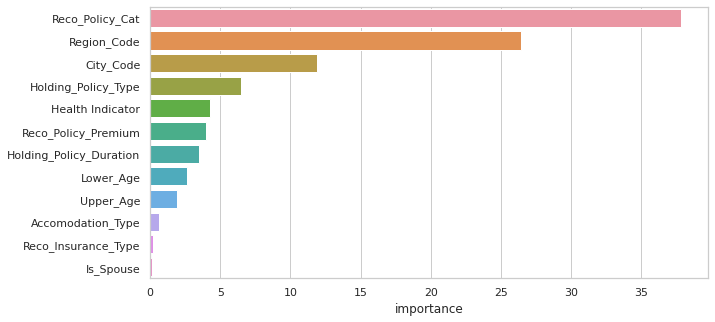

In [ ]:
f_importance_df = pd.DataFrame(bst.get_feature_importance(), columns=['importance'], index=X_valid.columns)
f_importance_df = f_importance_df.sort_values(by='importance', ascending=False)


plt.figure(figsize=(10,5))
sns.barplot(x=f_importance_df.importance[:500], y=f_importance_df.index[:500]);

In [ ]:

def plot_roc(y_trues, y_preds, labels, x_max=1.0):
    fig, ax = plt.subplots()
    for i, y_pred in enumerate(y_preds):
        y_true = y_trues[i]
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)
        ax.plot(fpr, tpr, label='%s; AUC=%.3f' % (labels[i], auc), marker='o', markersize=1)

    ax.legend()
    ax.grid()
    ax.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), linestyle='--')
    ax.set_title('ROC curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_xlim([-0.01, x_max])
    _ = ax.set_ylabel('True Positive Rate')

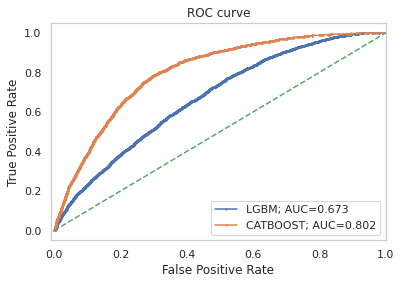

In [ ]:

plot_roc(
    [y_valid]*2,
    [ypred_lgb, ypred_cat],
    ['LGBM', 'CATBOOST']
)

In [ ]:
data_train.groupby('City_Code')['Response'].mean()

City_Code
C1     0.246072
C10    0.225947
C11    0.243243
C12    0.228111
C13    0.253731
C14    0.235925
C15    0.213322
C16    0.237004
C17    0.228645
C18    0.238394
C19    0.231368
C2     0.244353
C20    0.228942
C21    0.228277
C22    0.230620
C23    0.265758
C24    0.235081
C25    0.240437
C26    0.216433
C27    0.257627
C28    0.235088
C29    0.235142
C3     0.237472
C30    0.310345
C31    0.133333
C32    0.287500
C33    0.248252
C34    0.276923
C35    0.285714
C36    0.138889
C4     0.242168
C5     0.230205
C6     0.235897
C7     0.253403
C8     0.241971
C9     0.233410
Name: Response, dtype: float64

In [ ]:
data_train.groupby("City_Code")['Reco_Policy_Premium'].rank(method='first',ascending=True)

0        2102.0
1        1343.0
2         234.0
3         381.0
4         674.0
          ...  
50877     826.0
50878      78.0
50879    2331.0
50880    8287.0
50881    2032.0
Name: Reco_Policy_Premium, Length: 50882, dtype: float64

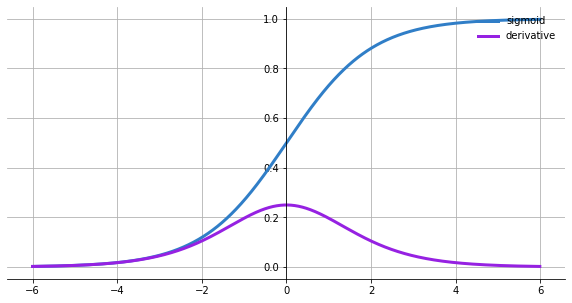

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def sigmoid(x):
    s=1/(1+np.exp(-x))
    ds=s*(1-s)  
    return s,ds
x=np.arange(-6,6,0.01)
sigmoid(x)
# Setup centered axes
fig, ax = plt.subplots(figsize=(10, 5))
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
# Create and show plot
ax.plot(x,sigmoid(x)[0], color="#307EC7", linewidth=3, label="sigmoid")
ax.plot(x,sigmoid(x)[1], color="#9621E2", linewidth=3, label="derivative")
ax.legend(loc="upper right", frameon=False)
fig.show()
plt.grid()

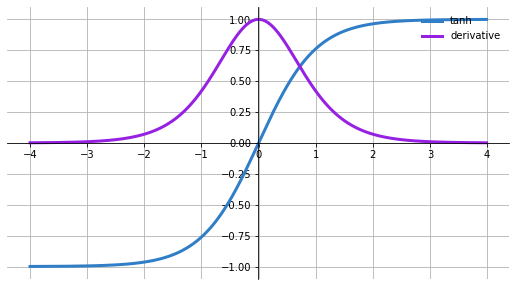

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def tanh(x):
    t=(np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
    dt=1-t**2
    return t,dt
z=np.arange(-4,4,0.01)
#print(tanh(z)[0])
tanh(z)[0].size,tanh(z)[1].size
# Setup centered axes
fig, ax = plt.subplots(figsize=(9, 5))
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
# Create and show plot
ax.plot(z,tanh(z)[0], color="#307EC7", linewidth=3, label="tanh")
ax.plot(z,tanh(z)[1], color="#9621E2", linewidth=3, label="derivative")
ax.legend(loc="upper right", frameon=False)
fig.show()
plt.grid()

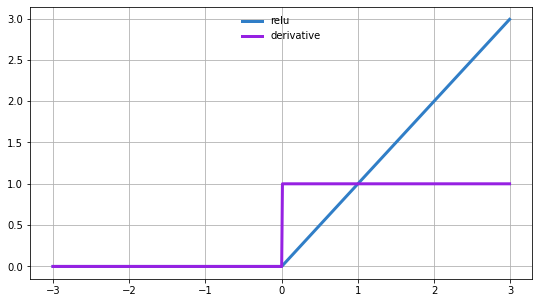

In [ ]:
  import matplotlib.pyplot as plt
  import numpy as np

  def relu(x):
    r = [max(i,0) for i in x]
    dr = [1 if i >0  else 0 for i in x]
    return r , dr
    
  z=np.arange(-3,3,0.01)
  r , dr = relu(z)
  # Setup centered axes
  fig, ax = plt.subplots(figsize=(9, 5))

  ax.xaxis.set_ticks_position('bottom')
  ax.yaxis.set_ticks_position('left')
  # Create and show plot
  ax.plot(z,r, color="#307EC7", linewidth=3, label="relu")
  ax.plot(z,dr, color="#9621E2", linewidth=3, label="derivative")
  ax.legend(loc="upper center", frameon=False)
  fig.show()
  plt.grid()

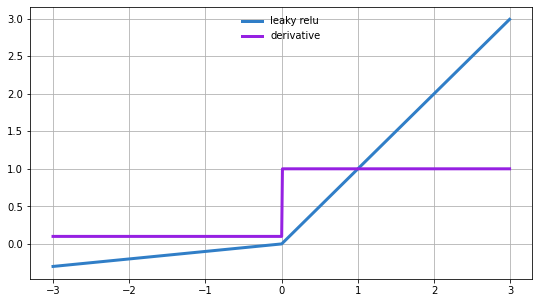

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def relu(x,k):
  lr = [max(i,k*i) for i in x]
  dlr = [1 if i >0  else k for i in x]
  return lr , dlr
  
z=np.arange(-3,3,0.01)
k = 0.1
lr , dlr = relu(z,k)

fig, ax = plt.subplots(figsize=(9, 5))

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
# Create and show plot
ax.plot(z,lr, color="#307EC7", linewidth=3, label="leaky relu")
ax.plot(z,dlr, color="#9621E2", linewidth=3, label="derivative")
ax.legend(loc="upper center", frameon=False)
fig.show()
plt.grid()

In [ ]:
ls = [max(i,0) for i in k]
ls

[0, 0, 1, 2, 3]

In [ ]:
x=np.arange(-3,3,0.01)
dr = [1 if i >0  else 0 for i in x]

In [ ]:
dr

[0, 0, 1, 1, 1]